In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [27]:
train=pd.read_csv("Titanic_train.csv")
test=pd.read_csv("Titanic_test.csv")

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

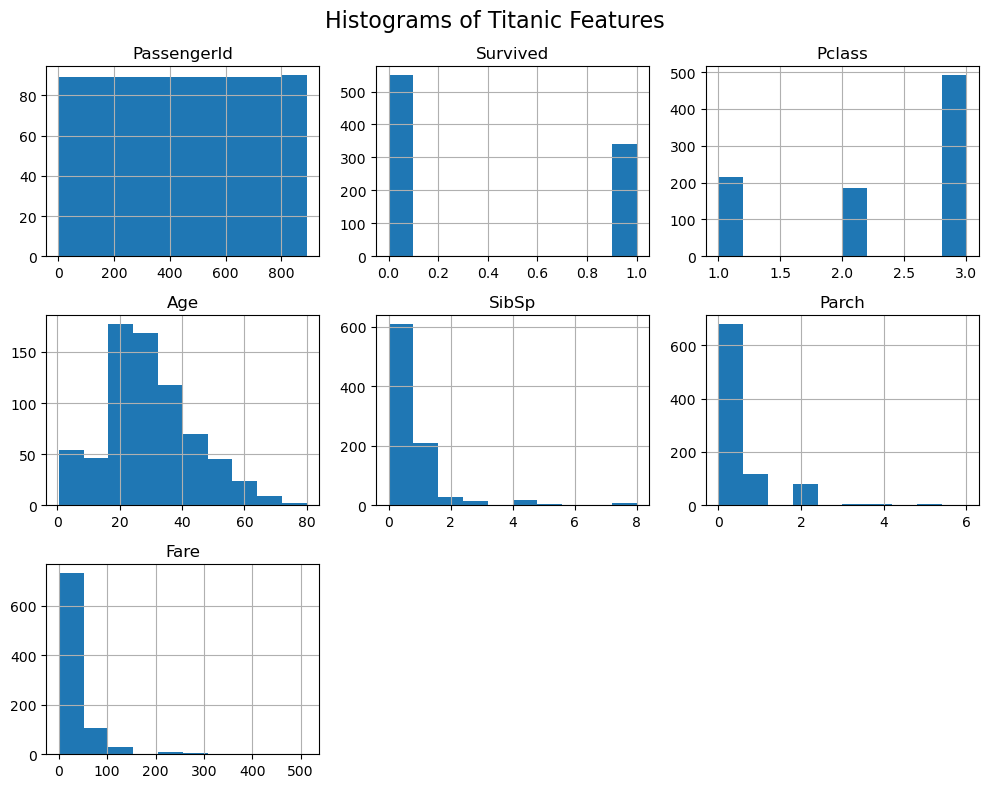

In [28]:
# Visualize distributions
train.hist(figsize=(10,8))
plt.suptitle("Histograms of Titanic Features",fontsize=16)
plt.tight_layout()
plt.show()

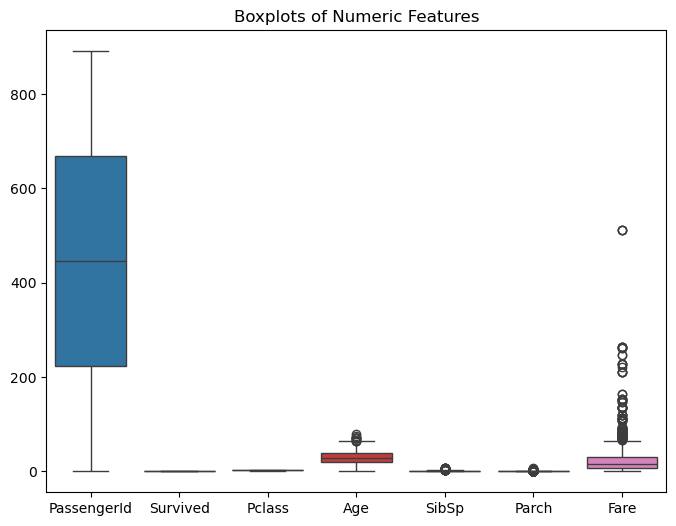

In [29]:
# Box plots
plt.figure(figsize=(8,6))
sns.boxplot(data=train.select_dtypes(include=np.number))
plt.title("Boxplots of Numeric Features")
plt.show()

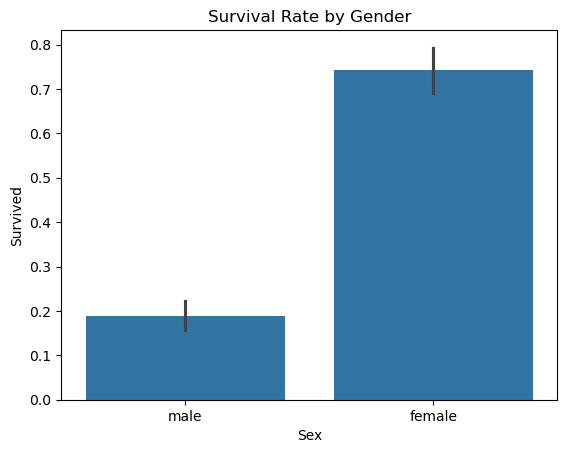

In [30]:
# Relationship with survival
sns.barplot(x="Sex",y="Survived",data=train)
plt.title("Survival Rate by Gender")
plt.show()

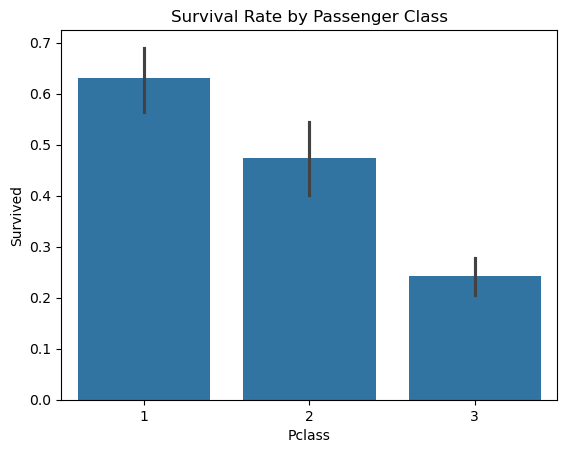

In [31]:
sns.barplot(x="Pclass",y="Survived",data=train)
plt.title("Survival Rate by Passenger Class")
plt.show()

In [32]:
#Data Preprocessing
test['Survived']=np.nan
combined=pd.concat([train,test],sort=False)

In [33]:
combined['Age'].fillna(combined['Age'].median(),inplace=True)
combined['Embarked'].fillna(combined['Embarked'].mode()[0],inplace=True)
combined['Fare'].fillna(combined['Fare'].median(),inplace=True)

In [34]:
combined.drop(['Cabin','Name','Ticket','PassengerId'],axis=1,inplace=True)

In [35]:
le=LabelEncoder()
for col in ['Sex','Embarked']:
    combined[col]=le.fit_transform(combined[col])

In [36]:
# Split back to train/test
train_processed=combined[combined['Survived'].notnull()]
test_processed=combined[combined['Survived'].isnull()].drop("Survived",axis=1)

In [37]:
X=train_processed.drop("Survived",axis=1)
y=train_processed["Survived"]

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [39]:
lgb_model=lgb.LGBMClassifier()
lgb_model.fit(X_train,y_train)
y_pred_lgb=lgb_model.predict(X_test)

print("LightGBM Classification Report:")
print(classification_report(y_test,y_pred_lgb))

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [40]:
xgb_model=xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
xgb_model.fit(X_train,y_train)
y_pred_xgb=xgb_model.predict(X_test)

print("XGBoost Classification Report:")
print(classification_report(y_test,y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       105
         1.0       0.76      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [41]:
lgb_cv=cross_val_score(lgb_model,X,y,cv=5,scoring='accuracy')
xgb_cv=cross_val_score(xgb_model,X,y,cv=5,scoring='accuracy')

print(f"LightGBM Mean CV Accuracy: {lgb_cv.mean():.4f}")
print(f"XGBoost Mean CV Accuracy: {xgb_cv.mean():.4f}")

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [42]:
#Confusion Matrices
plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'LightGBM Confusion Matrix')

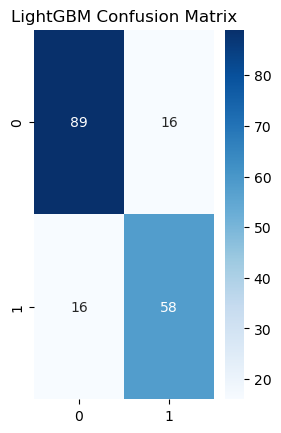

In [45]:
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_lgb),annot=True,fmt="d",cmap="Blues")
plt.title("LightGBM Confusion Matrix")

Text(0.5, 1.0, 'XGBoost Confusion Matrix')

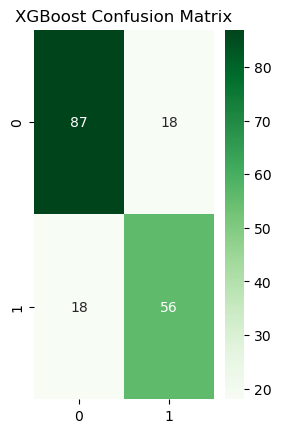

In [46]:
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),annot=True,fmt="d",cmap="Greens")
plt.title("XGBoost Confusion Matrix")

In [25]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [26]:
#LightGBM achieved an accuracy of X% while XGBoost achieved Y% (from your output).
#LightGBM was slightly faster and easier to tune.
#XGBoost offered better control with regularization and worked well with categorical encoding.
#In practice, LightGBM may be preferred for large datasets, while XGBoost might give slightly better performance after tuning.